<a href="https://colab.research.google.com/github/Arashsm/Timeseries_forcasting_corono_dataset/blob/main/Covid_Forcasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot
import statsmodels as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import statistics
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys, os
import warnings
warnings.simplefilter(action='ignore')
#import fbprophet
#import pmdarima as pm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
df = pd.read_csv('covid_19_data.csv',parse_dates=['ObservationDate'])
# groupying each row by its Country/Region and choosing just the confirmed 
group_var = ['ObservationDate','Country/Region']
out_var = ['Confirmed' ]
base = df.groupby(group_var)[out_var].sum().reset_index()
# using Observationdate as index
base.set_index('ObservationDate', inplace=True)


In [ ]:
# extracting datas related to Germany from the data
base_Germany = base.loc[base['Country/Region'] == 'Germany'] 
# resampling the data from daily to weekly to mediate the effects of lower amount of test at weekend
Germany_Weekly = base_Germany.resample('W').sum()
Germany_Weekly['per_week'] = Germany_Weekly['Confirmed'] - Germany_Weekly['Confirmed'].shift(1)
Germany_Weekly['per_week'][0] = Germany_Weekly['Confirmed'][0]
Germany_Weekly = Germany_Weekly.drop(Germany_Weekly.index[69])
Germany_Weekly['diff'] = Germany_Weekly['per_week'].diff()
Germany_Weekly = Germany_Weekly.drop(Germany_Weekly.index[0])


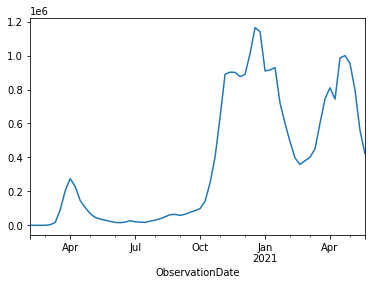

In [ ]:
Germany_Weekly['per_week'].plot()

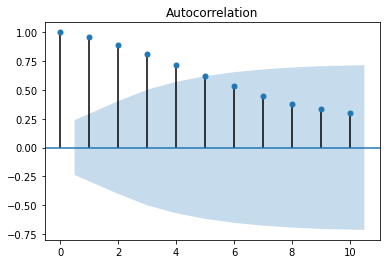

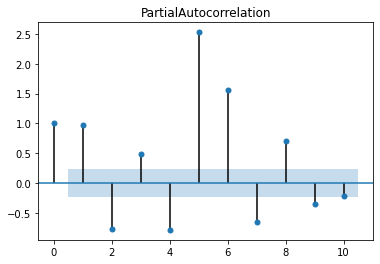

In [ ]:
# in order to figure out which is the right model we use ACF anf PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot, quarter_plot
acf_plot = plot_acf(Germany_Weekly['per_week'], lags=10, title='Autocorrelation')
pacf_plot = plot_pacf(Germany_Weekly['per_week'], lags=10, title='PartialAutocorrelation')

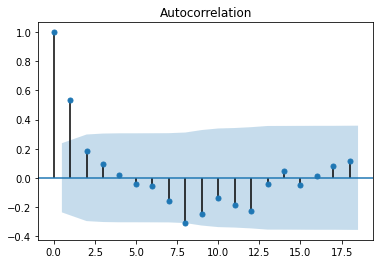

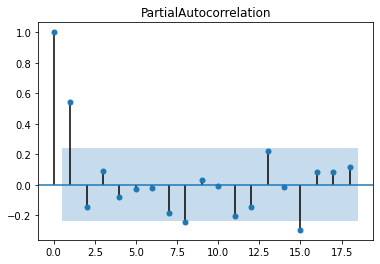

In [ ]:
# we use the diff of the real data to acquire better underasting 
acf_plot = plot_acf(Germany_Weekly['diff'], lags=18, title='Autocorrelation')
pacf_plot = plot_pacf(Germany_Weekly['diff'], lags=18, title='PartialAutocorrelation')

In [ ]:
mod = sm.tsa.statespace.SARIMAX(Germany_Weekly['per_week'], trend='n', order=(1,1,0)).fit()

In [ ]:
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:               per_week   No. Observations:                   68
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -850.020
Date:                Wed, 25 May 2022   AIC                           1704.039
Time:                        11:34:27   BIC                           1708.449
Sample:                    02-09-2020   HQIC                          1705.784
                         - 05-23-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5536      0.080      6.900      0.000       0.396       0.711
sigma2      6.218e+09    1.3e-12    4.8e+21      0.000    6.22e+09    6.22e+09
===================================================================================
Ljung-Box (Q):                       32.28   Jarque-Bera (JB):                17.97
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):              14.29   Skew:                             0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

In [ ]:
def plots(data, lags=None):
    layout = (1, 2)
#     raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 0))
    pacf = plt.subplot2grid(layout, (0, 1))
    
#     raw.plot(data)
    sm.tsa.graphics.plot_acf(data, lags=lags, ax=acf, zero=False)
    sm.tsa.graphics.plot_pacf(data, lags=lags, ax=pacf, zero = False)
    sns.despine()
    plt.tight_layout()

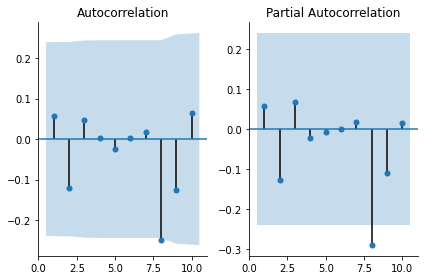

In [ ]:
plots(mod.resid[mod.loglikelihood_burn:], lags=10)

In [ ]:
Germany_Weekly['forecast'] = mod.predict(start = 0, end= 68) 

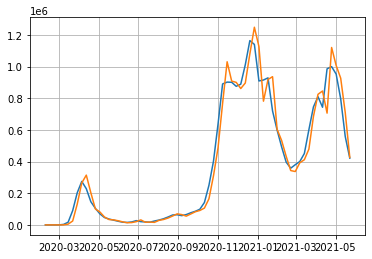

In [ ]:
plt.plot(Germany_Weekly[0:][['per_week', 'forecast']])
plt.grid();

In [ ]:

smod = sm.tsa.statespace.SARIMAX(Germany_Weekly['per_week'], trend='n', order=(1,0,0), seasonal_order=(0,1,1,8)).fit()
smod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                          per_week   No. Observations:                   68
Model:             SARIMAX(1, 0, 0)x(0, 1, 1, 8)   Log Likelihood                -785.403
Date:                           Wed, 25 May 2022   AIC                           1576.805
Time:                                   11:39:02   BIC                           1583.088
Sample:                               02-09-2020   HQIC                          1579.263
                                    - 05-23-2021                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9718      0.068     14.233      0.000       0.838       1.106
ma.S.L8       -0.8026      0.313     -2.567      0.010      -1.415      -0.190
sigma2      2.172e+10   1.16e-11   1.87e+21      0.000    2.17e+10    2.17e+10
===================================================================================
Ljung-Box (Q):                       78.90   Jarque-Bera (JB):                 1.71
Prob(Q):                              0.00   Prob(JB):                         0.42
Heteroskedasticity (H):              14.64   Skew:                             0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.13e+36. Standard errors may be unstable.
"""

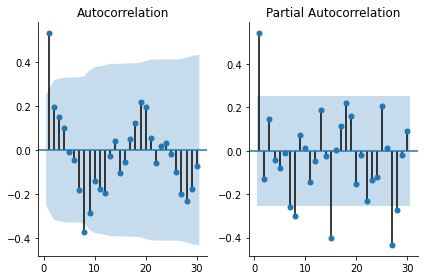

In [ ]:
plots(smod.resid[smod.loglikelihood_burn:], lags=30)

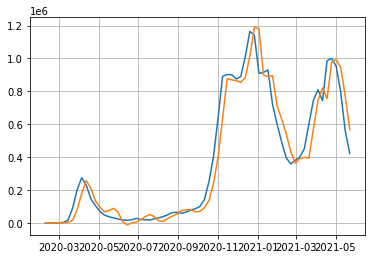

In [ ]:
Germany_Weekly['sforecast'] = smod.predict(start = 0, end= 68)
plt.plot(Germany_Weekly[0:][['per_week', 'sforecast']])
plt.grid();

In [ ]:
import pmdarima as pm
stepwise_model = pm.auto_arima(Germany_Weekly['per_week'], start_p=0, start_q=0,
                           max_p=3, max_q=3, m=8,
                           start_P=0, seasonal=True,
                           d=0, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,1)[8] intercept   : AIC=1698.001, Time=0.07 sec
 ARIMA(0,0,0)(0,1,0)[8] intercept   : AIC=1716.792, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[8] intercept   : AIC=1583.794, Time=0.09 sec
 ARIMA(0,0,1)(0,1,1)[8] intercept   : AIC=1668.702, Time=0.14 sec
 ARIMA(0,0,0)(0,1,0)[8]             : AIC=1719.194, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[8] intercept   : AIC=1603.694, Time=0.03 sec
 ARIMA(1,0,0)(2,1,0)[8] intercept   : AIC=1579.349, Time=0.30 sec
 ARIMA(1,0,0)(2,1,1)[8] intercept   : AIC=1578.754, Time=0.45 sec
 ARIMA(1,0,0)(1,1,1)[8] intercept   : AIC=1577.466, Time=0.33 sec
 ARIMA(1,0,0)(0,1,1)[8] intercept   : AIC=1579.702, Time=0.12 sec
 ARIMA(1,0,0)(1,1,2)[8] intercept   : AIC=1578.873, Time=0.50 sec
 ARIMA(1,0,0)(0,1,2)[8] intercept   : AIC=1576.979, Time=0.33 sec
 ARIMA(0,0,0)(0,1,2)[8] intercept   : AIC=1699.999, Time=0.19 sec
 ARIMA(2,0,0)(0,1,2)[8] intercept   : AIC=1551.069, Time=0.27 sec
 ARIMA(2,0,0)(0,1,1)[8] intercept

In [ ]:
asmod = sm.tsa.statespace.SARIMAX(Germany_Weekly['per_week'], trend='n', order=(2,0,0), seasonal_order=(0,1,2,8)).fit()
asmod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                          per_week   No. Observations:                   68
Model:             SARIMAX(2, 0, 0)x(0, 1, 2, 8)   Log Likelihood                -769.816
Date:                           Wed, 25 May 2022   AIC                           1549.631
Time:                                   11:46:55   BIC                           1560.103
Sample:                               02-09-2020   HQIC                          1553.727
                                    - 05-23-2021                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5048      0.172      8.773      0.000       1.169       1.841
ar.L2         -0.5368      0.170     -3.163      0.002      -0.869      -0.204
ma.S.L8       -1.0953      0.293     -3.736      0.000      -1.670      -0.521
ma.S.L16       0.3900      0.327      1.192      0.233      -0.251       1.031
sigma2      1.286e+10   1.57e-11   8.17e+20      0.000    1.29e+10    1.29e+10
===================================================================================
Ljung-Box (Q):                       27.15   Jarque-Bera (JB):                 7.16
Prob(Q):                              0.94   Prob(JB):                         0.03
Heteroskedasticity (H):              22.13   Skew:                             0.33
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.76e+36. Standard errors may be unstable.
"""

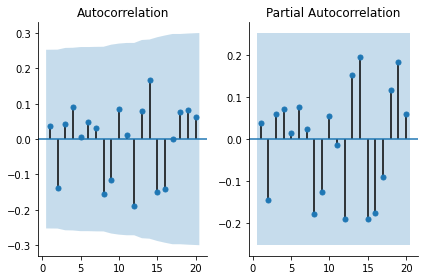

In [ ]:
plots(asmod.resid[asmod.loglikelihood_burn:], lags=20)

In [ ]:
Germany_Weekly['asforecast'] = asmod.predict(start = 0, end= 68)

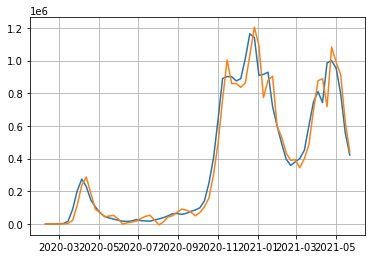

In [ ]:
plt.plot(Germany_Weekly[0:][['per_week','asforecast']])
plt.grid();

In [ ]:
asmod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                          per_week   No. Observations:                   68
Model:             SARIMAX(2, 0, 0)x(0, 1, 2, 8)   Log Likelihood                -769.816
Date:                           Wed, 25 May 2022   AIC                           1549.631
Time:                                   11:41:28   BIC                           1560.103
Sample:                               02-09-2020   HQIC                          1553.727
                                    - 05-23-2021                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5048      0.172      8.773      0.000       1.169       1.841
ar.L2         -0.5368      0.170     -3.163      0.002      -0.869      -0.204
ma.S.L8       -1.0953      0.293     -3.736      0.000      -1.670      -0.521
ma.S.L16       0.3900      0.327      1.192      0.233      -0.251       1.031
sigma2      1.286e+10   1.57e-11   8.17e+20      0.000    1.29e+10    1.29e+10
===================================================================================
Ljung-Box (Q):                       27.15   Jarque-Bera (JB):                 7.16
Prob(Q):                              0.94   Prob(JB):                         0.03
Heteroskedasticity (H):              22.13   Skew:                             0.33
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.76e+36. Standard errors may be unstable.
"""

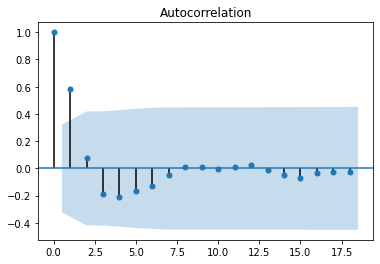

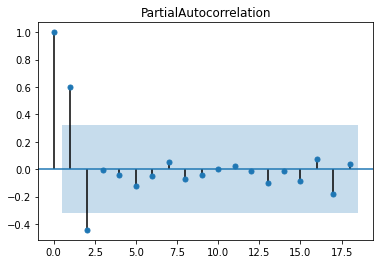

In [ ]:
# here we divide the time series into two parts
acf_plot = plot_acf(Germany_Weekly['diff'][:37], lags=18, title='Autocorrelation')
pacf_plot = plot_pacf(Germany_Weekly['diff'][:37], lags=18, title='PartialAutocorrelation')

In [ ]:
fhmod = sm.tsa.statespace.SARIMAX(Germany_Weekly['per_week'][:38], trend='n', order=(2,1,1)).fit()
Germany_Weekly['fdforecast'] = fhmod.predict(start = 0, end= 38)
fhmod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:               per_week   No. Observations:                   38
Model:               SARIMAX(2, 1, 1)   Log Likelihood                -420.521
Date:                Wed, 25 May 2022   AIC                            849.042
Time:                        12:22:28   BIC                            855.486
Sample:                    02-09-2020   HQIC                           851.314
                         - 10-25-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0611      0.210      5.049      0.000       0.649       1.473
ar.L2         -0.4855      0.136     -3.569      0.000      -0.752      -0.219
ma.L1          0.5960      0.256      2.329      0.020       0.094       1.098
sigma2      4.839e+08   1.61e-10   3.01e+18      0.000    4.84e+08    4.84e+08
===================================================================================
Ljung-Box (Q):                         nan   Jarque-Bera (JB):                 6.67
Prob(Q):                               nan   Prob(JB):                         0.04
Heteroskedasticity (H):               0.53   Skew:                             0.03
Prob(H) (two-sided):                  0.29   Kurtosis:                         5.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.43e+35. Standard errors may be unstable.
"""

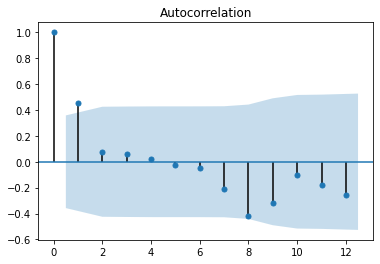

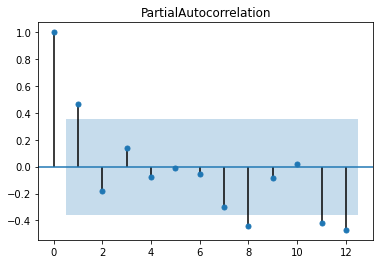

In [ ]:
acf_plot = plot_acf(Germany_Weekly['diff'][38:], lags=12, title='Autocorrelation')
pacf_plot = plot_pacf(Germany_Weekly['diff'][38:], lags=12, title='PartialAutocorrelation')

In [ ]:
shmod = sm.tsa.statespace.SARIMAX(Germany_Weekly['per_week'][38:], trend='n', order=(2,1,1)).fit()
Germany_Weekly['sdforecast'] = shmod.predict(start = 0, end=30)

In [ ]:
Germany_Weekly= Germany_Weekly.fillna(0)
Germany_Weekly['dforecast'] = Germany_Weekly['fdforecast'] + Germany_Weekly['sdforecast']


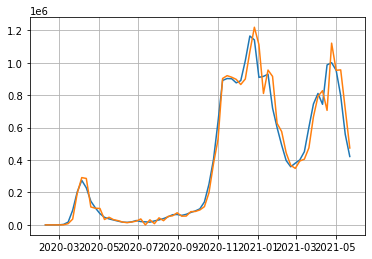

In [ ]:
plt.plot(Germany_Weekly[0:][['per_week','dforecast']])
plt.grid();